# Subnetwork Construction

Given our network is so noisy, in order to further magnify the effects that the MTB proteins are having on the network, we will next conduct a community and centrality analysis on a subnetwork that contains a subset of the macrophage proteins which interact with Mtb proteins. In order to do this, we must first construct the subnetworks.

This notebook will be used to construct the 2nd degree healthy and diseased subnetworks that will be used for further analysis. The diseased 2nd degree network will consist of all the Mtb proteins, their direct interactions. and the neighbors of those interactions. The healthy subnetwork will consist of the same graph, without the the Mtb interactions. 

In [2]:
#imports 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 

#Import healthy graph
file1 = open("../Data/Macrophage_healthy_graph_with_cleaned_attributes.pkl", "rb")
GX = nx.read_gpickle(file1)

#Import diseased graph
file2 = open("../Data/Macrophage_diseased_graph_with_cleaned_attributes.pkl", "rb")
GZ = nx.read_gpickle(file2)

#examine
print(GX)
print(GZ)

Graph named 'Healthy Network' with 3057 nodes and 4733 edges
Graph named 'Diseased Network' with 3069 nodes and 4755 edges


In [4]:
#Define functions that will be used in this notebook

#Function for getting neighborhood nodes
def neighbor_puller(graph, nodelist, degree) -> list:
    """Takes a reference graph, a nodelist of choice, and a degree (either 1,2,3) and returns a list of 
    the unique neighborhood ndes of the chosen degree for the given nodelist, including the given nodes."""
    neighbor_list = []
    for node in nodelist:
        node = str(node)
        neighbor_list.append(node)

        #first degree
        if degree == 1:
            for first_neighbor in graph.neighbors(node):
                neighbor_list.append(first_neighbor)
        #Second degree
        elif degree == 2:
             for first_neighbor in graph.neighbors(node):
                neighbor_list.append(first_neighbor)
                for second_neighbor in graph.neighbors(first_neighbor):
                    if second_neighbor != node:
                        neighbor_list.append(second_neighbor)
        #Third degree
        elif degree == 3:
             for first_neighbor in graph.neighbors(node):
                neighbor_list.append(first_neighbor)
                for second_neighbor in graph.neighbors(first_neighbor):
                    if second_neighbor != node:
                        neighbor_list.append(second_neighbor)
                        for third_neighbor in graph.neighbors(second_neighbor):
                            if third_neighbor != node:
                                neighbor_list.append(third_neighbor)
    #Filter unqiue
    return_list = [] 
    for i in neighbor_list:
        if i not in return_list:
            return_list.append(i)
    
    return(neighbor_list)

#Function for assembling edges
def edge_puller(node_list, graph) -> list:
    """Function inputs a list of nodes and a reference graph and returns a sublist of all edges containing those nodes.
    Note that the function returns additional interactions of a higher degree that are inclusive to the node list. 
    Example: network of second degree nodes contains inclusive interactions of the third degree, so those edges get included as well."""
    edge_list = []
    for edge in graph.edges():
        if (edge[0] in node_list) and (edge[1] in node_list):
            edge_list.append(edge)
    return(edge_list)


In [13]:
#Constants used 

#List of Mtb edges within the human macrophage - see Network construction for methods
Mtb_edges = [
('Q7L591', 'Apa'),
('P50552', 'Apa'),
('Q9UI08', 'Apa'),
('Q15654', 'Apa'),
('Q16543', 'LpqR'),
('Q15287', 'Rv1827'),
('Q9C005', 'Rv1075C'),
('Q9C005', 'Rv1074c'),
('Q14847', 'Rv3033'),
('Q14005', 'Rv3033'),
('P22681', 'LpqN'),
('P20339', 'TB8.4'),
('P51610', 'Rv3668c'),
('P12956', 'EspR'),
('P62820', 'ESAT6'),
('Q15233', 'Apa'),
('Q07812', 'PE25'),
('O95466', 'LpqN'),
('Q9NXV2', 'LpqN'),
('Q15154', 'Rv1827'),
('Q01130', 'Rv1827'),
('O60488', 'PE25')]

# #write list to file 
# import csv
# with open("../Data/mtb_interactions.csv","w") as file:
#     csv_out = csv.writer(file)
#     csv_out.writerows(Mtb_edges)

mtb_node_names = [
'Rv3033',
'Apa',
'PE25',
'Rv1827',
'LpqN',
'Rv1075C',
'Rv1074c',
'LpqR',
'EspR',
'TB8.4',
'Rv3668c',
'ESAT6']


## Assembling the Healthy Subnetwork

In order to construct the healthy 2nd degree subnetwork, we will first compile a list of all the human macrophage proteins which have been shown to interact with Mtb.

In [11]:
#Given list of Mtb-human protein interactions (Mtb_edges), pull out the the list of human proteins:
mtb_human_prot_list = []
for pair in Mtb_edges: #ordered list of observed interactions so all human interactions are position 0
    if pair[0] in GX.nodes():
        mtb_human_prot_list.append(pair[0])

#Make the list unique, removing duplicates
mtb_human_prot_list = list(set(mtb_human_prot_list))

Now that we have all the direct mtb interactions, we can compile a list of all the second degree nodes for each of the Mtb proteins.

In [36]:
#Call function to get healthy subnetwork nodes - 
#  note that the degree is 1 because 
#  we aren't including Mtb proteins, so from the perspective of the human proteins, 
#  its the first degree neighbors we want 
healthy_sub_nodes = neighbor_puller(GX,mtb_human_prot_list,degree=1) 

#Call function to assemble edges based on healthy subnetwork nodes
healthy_sub_edges = edge_puller(healthy_sub_nodes,GX)

#Create and save graph
Gx = nx.Graph(name = "Macrophage_healthy_2nd_degree_subgraph")
Gx.add_edges_from(healthy_sub_edges)

#Add attributes to new graph which got lost in the transfer process
for node in Gx.nodes():
    for attribute in list(GX.nodes['P20333'].keys()): #gets list of all atrributes
        Gx.nodes[node][attribute] = GX.nodes[node][attribute]
        
#Examine new subgraph
print(Gx)

#Save graph
#nx.write_gpickle(Gx, '../Data/Graphs/Macrophage_healthy_2nd_degree_subgraph_with_cleaned_attributes.pkl')

Graph named 'Macrophage_healthy_2nd_degree_subgraph' with 84 nodes and 97 edges


Now that we have our graph, let's take a quick look at it.

No handles with labels found to put in legend.


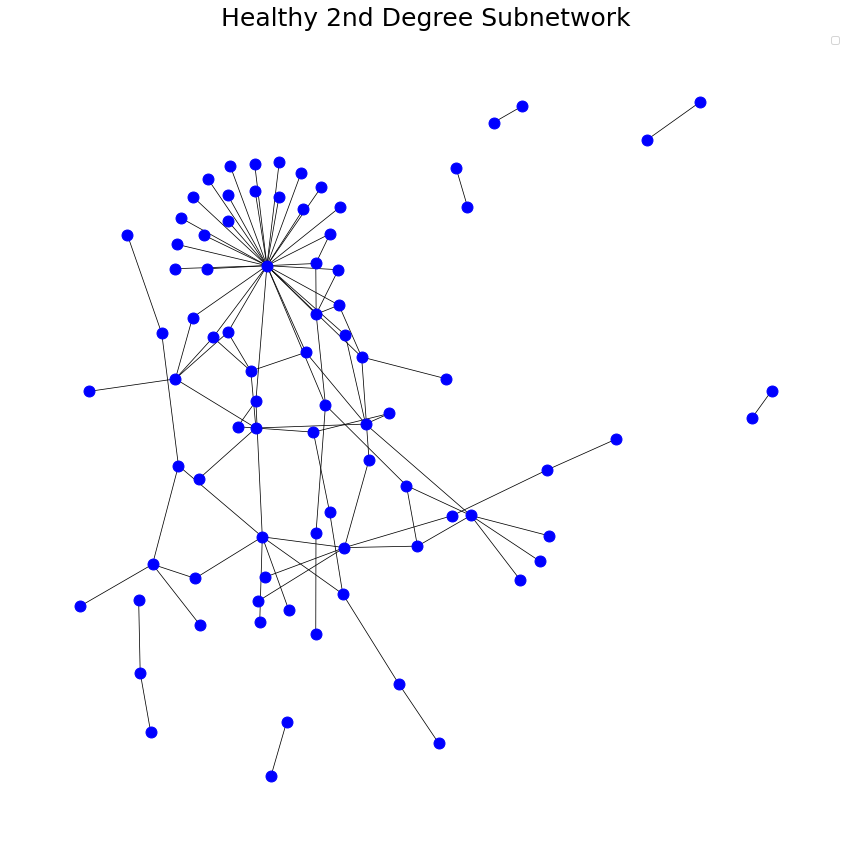

In [40]:
#set fig dimensions
sub_healthy, ax = plt.subplots(figsize =(15,15))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(Gx, iterations=20, k=0.09, seed = 15)
     
#Draw nodes w/ color map
nx.draw_networkx_nodes(Gx, 
                       pos, 
                       node_size=120,
                       alpha = 1,
                       nodelist = Gx.nodes(), 
                       node_color = 'blue'
                      )

#Draw Edges        
nx.draw_networkx_edges(Gx, pos, width=0.75)

ax.set_facecolor('white')
ax.axis('off')

#Plot Labels
name = "Healthy 2nd Degree Subnetwork"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
plt.legend(scatterpoints=1)

plt.show()
#sub_healthy.savefig("../Plots/healthy_2nd_degree_sub_constructed_plot.jpg", dpi=300)

## Assembling the Diseased Subnetwork

Next we will assemble the diseased 2nd degree subnetwork. This will be easy because all we have to do now is add back in the diseased edges.

In [41]:
#Creating Diseased Subnetwork 

Gz = nx.Graph(name = "Macrophage_diseased_2nd_degree_subgraph")

#Copies edges from healthy subgraph and adds the MTB edges
Gz.add_edges_from(Gx.edges())
Gz.add_edges_from(Mtb_edges)

#Add back all attributes that got lost in transfer
for node in Gz.nodes():
    for attribute in list(GX.nodes['P20333'].keys()): #gets list of all atrributes
        if node in mtb_node_names:
            Gz.nodes[node][attribute] = 'Mtb'  #filler for attributes
        else:
            Gz.nodes[node][attribute] = GX.nodes[node][attribute]
#test
print(Gz)
#nx.write_gpickle(Gz, '../Data/Graphs/Macrophage_diseased_2nd_degree_subgraph_with_cleaned_attributes.pkl')

Graph named 'Macrophage_diseased_2nd_degree_subgraph' with 96 nodes and 119 edges


Now let's visualize the diseased subnetwork

No handles with labels found to put in legend.


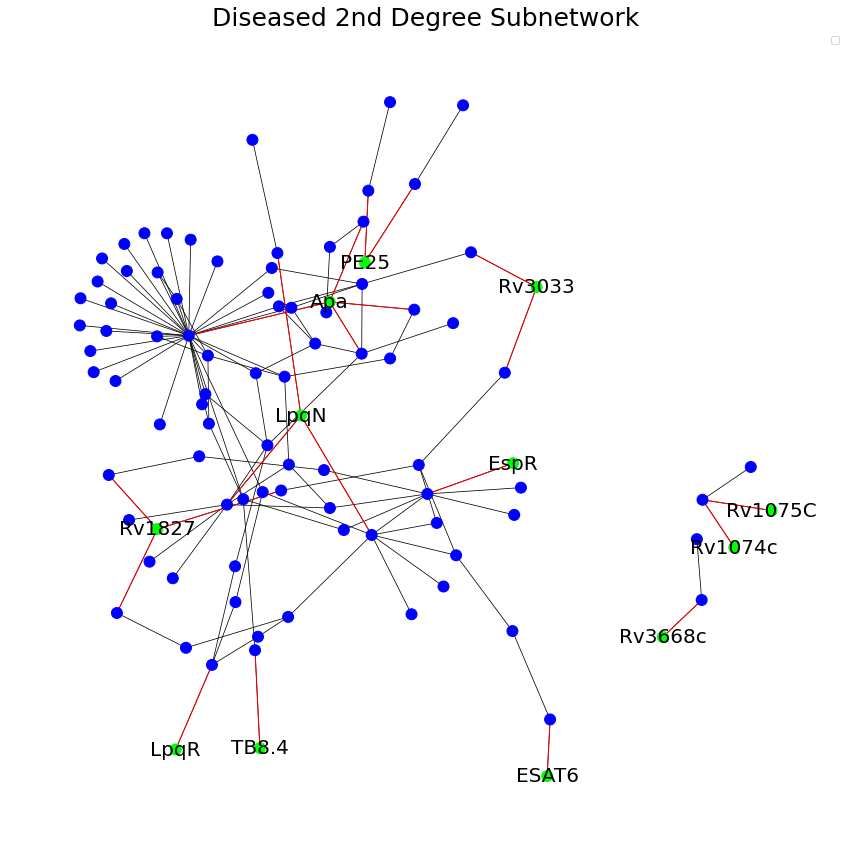

In [38]:
#set fig dimensions
sub_diseased, ax = plt.subplots(figsize =(15,15))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(Gz, iterations=20, k=0.09, seed = 15)

#set color map
color_map = []
for i in Gz.nodes:
    if i in mtb_node_names:
        color_map.append('lime')
    else:
        color_map.append('blue')

#Draw nodes w/ color map
nx.draw_networkx_nodes(Gz, 
                       pos, 
                       node_size=120,
                       alpha = 1,
                       nodelist = Gz.nodes(), 
                       node_color = color_map
                      )

#Label mtb nodes
labels_to_add = {}
for node in mtb_node_names:
    labels_to_add[node] = node

nx.draw_networkx_labels(Gz,
                        pos,
                        labels = labels_to_add,
                        font_size = 20)

#Draw Edges        
nx.draw_networkx_edges(Gz, pos, width=0.75)
nx.draw_networkx_edges(Gz, pos, edgelist=Mtb_edges, edge_color='red', width = 1)


ax.set_facecolor('white')
ax.axis('off')

#Plot Labels
name = "Diseased 2nd Degree Subnetwork"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
plt.legend(scatterpoints=1)

plt.show()
#sub_diseased.savefig("../Plots/diseased_2nd_degree_sub_constructed_plot.jpg", dpi=300)

Now we have our 2nd degree subnetworks constructed, we can begin our analysis of the subnetwork.